In [57]:
import filter as filter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

In [107]:
def displayImage(image_as_np_array, input_cmap=plt.get_cmap()):
    # Display the filtered image 
    plt.imshow(image_as_np_array, cmap=input_cmap)
    plt.show()

In [108]:
# Read in the image
original_image = mpimg.imread('exit-ramp.jpg')
original_image_grayscale = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)

In [119]:
# Gaussian Blur
# Define a kernel size for Gaussian smoothing / blurring
kernel_size = 5 # Must be an odd number (3, 5, 7...)
image_blur_gray = cv2.GaussianBlur(original_image_grayscale, (kernel_size, kernel_size), 0)

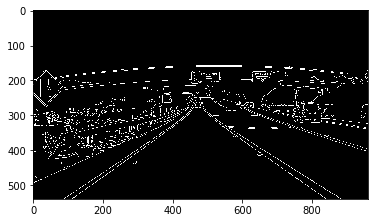

In [120]:
# Canny
# Define our parameters for Canny and run it
# Below low will be rejected and only the ones in the range directly attached to pixels
#   above high will be kept.
canny_low_threshold = 50
canny_high_threshold = 150
canny_edges = cv2.Canny(image_blur_gray, canny_low_threshold, canny_high_threshold)
displayImage(canny_edges, 
             #input_cmap
             'Greys_r')

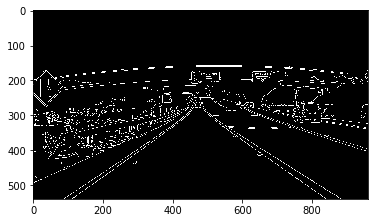

In [124]:
# Canny Mask
# Next we'll create a masked edges image using cv2.fillPoly()
ignore_mask_color = 255   
ignore_mask = np.zeros_like(canny_edges)   

# This time we are defining a four sided polygon to mask
original_image_shape = original_image.shape
ignore_polygon_vertices = np.array([[
                                    (original_image_shape[1]*2.2/5, original_image_shape[0]*3/5),
                                    (original_image_shape[1]*0.2/5, original_image_shape[0]),
                                    (original_image_shape[1]*4.8/5, original_image_shape[0]),
                                    (original_image_shape[1]*2.8/5, original_image_shape[0]*3/5)
                                   ]], 
                    dtype=np.int32)
cv2.fillPoly(ignore_mask, ignore_polygon_vertices, ignore_mask_color)
masked_canny_edges = cv2.bitwise_and(canny_edges, ignore_mask)

# Create a "color" binary image to combine with line image
masked_canny_color_edges = np.dstack((canny_edges, canny_edges, canny_edges)) 

displayImage(masked_canny_color_edges)

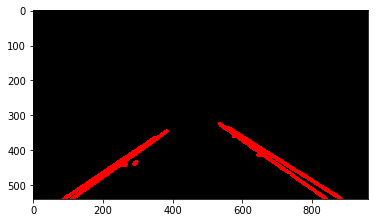

In [131]:
# Hough Lines
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
hough_line_image = np.copy(original_image)*0 # creating a blank to draw lines on
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 1     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 5 # minimum number of pixels making up a line
max_line_gap = 5    # maximum gap in pixels between connectable line segments

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(masked_canny_edges, rho, theta, threshold, np.array([]),
                        min_line_length, max_line_gap)

# Iterate over the output "lines" and draw lines on a blank image
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(hough_line_image, (x1,y1), (x2,y2), (255,0,0), 10)
        
displayImage(hough_line_image)

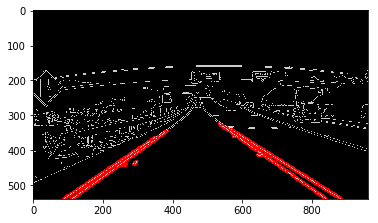

In [132]:
# Draw the lines on the edge image
masked_canny_edges_hough_line_image = cv2.addWeighted(masked_canny_color_edges, 0.8, hough_line_image, 1, 0) 
displayImage(masked_canny_edges_hough_line_image)